### Trabalho Final de INF-611 - Dados Complexos e Recuperação de Informação

Paulo Roberto de Almeida Costa

Renan Lordello de Aguiar

# Pré-Processamento

## Limpeza de Dados

Conforme fizemos no trabalho de INF-612, a limpeza deste dataset consiste em:

- Normalizar fuso horário para UTC-3, com cuidado particular nos dias em que o horário de verão começa ou acaba
- Remover linhas com erros (`NA`s e `Apparent Temperature = 99.9ºC`)
- Remover linhas duplicadas
- Manter apenas os anos 2015-2017

In [1]:
library(ggplot2)     # For charts
library("lubridate") # For timezone (with_tz)

# Read the dataset
cepagri.columns <- c("Time", "Temperature", "Wind", "Humidity", "Apparent Temperature")
cepagri <- read.csv("cepagri.csv", header = FALSE, sep = ";", col.names = cepagri.columns, stringsAsFactors = F)

# Parse each column
cepagri$Time <- as.POSIXlt(strptime(cepagri$Time, "%d/%m/%Y-%H:%M", tz = 'America/Sao_Paulo'))
cepagri$Temperature <- as.numeric(cepagri$Temperature)
cepagri$Wind <- as.numeric(cepagri$Wind)
cepagri$Humidity <- as.numeric(cepagri$Humidity)
cepagri$Apparent.Temperature <- as.numeric(cepagri$Apparent.Temperature)

# Fix ambiguous time parsing between 23:00 and 23:59 of the last day of the DST
fix.dst <- function(time) {
    for (i in 2:length(time)) {
        if (time[i] + 1800 < time[i - 1]) {
            time[i] <- time[i] + 3600
        }
    }
    time
}
cepagri$Time <- fix.dst(cepagri$Time)

# Use consistent timezone during the whole period (Recife uses UTC-3 and has no DST)
cepagri$Time <- with_tz(cepagri$Time, "America/Recife")

# Remove invalid rows
cepagri <- cepagri[!apply(cepagri, 1, function(x) {any(is.na(x))}), ]
cepagri <- cepagri[cepagri$Apparent.Temperature != 99.9, ]

# Remove repeated rows
is.repeated.row <- function(df) {
    ret <- logical(nrow(df))
    for (i in 2:nrow(df)) {
        ret[i] <- all(df[i, ] == df[i-1, ])
    }
    ret
}
cepagri <- cepagri[!is.repeated.row(cepagri[2:5]), ]

# Only keep 2015-2017
cepagri <- cepagri[ is.element(cepagri$Time$year, 115:117), ]


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

## Representação de Dados

Para a representação interna das séries temporais, faremos uma redução de dimensionalidade ao considerar apenas os valores médios de cada atributo em intervalos de 1h.

Serão descartados os dias em que, devido a algum erro, não houver dados em algum dos intervalos de 1h. No total, são descartados 23 dias, incluindo 3 dias que estavam presentes em `query.csv`.

In [2]:
cepagri.by.hour <- aggregate(cepagri[2:5], by=list(hour=cepagri$Time$hour, year=1900+cepagri$Time$year, month=1+cepagri$Time$mon, day=cepagri$Time$mday), FUN=mean)
cepagri.by.date <- unique(data.frame(year=1900+cepagri$Time$year, month=1+cepagri$Time$mon, day=cepagri$Time$mday))

for (hour in 0:23) {
    cepagri.by.date <- merge(
        cepagri.by.date, 
        cepagri.by.hour[cepagri.by.hour$hour == hour, 2:8], 
        by = c("year", "month", "day"),
        sort = T
    )
    new.col.indexes <- (4*hour+4):(4*hour+7)
    colnames(cepagri.by.date)[new.col.indexes] <- sprintf("%s.%d", colnames(cepagri.by.date)[new.col.indexes], hour)
}
cepagri.by.date <- cepagri.by.date[order(cepagri.by.date$year, cepagri.by.date$month, cepagri.by.date$day), ] 
row.names(cepagri.by.date) <- sprintf("%04d-%02d-%02d", cepagri.by.date$year, cepagri.by.date$month, cepagri.by.date$day)
cepagri.by.date <- cepagri.by.date[4:length(cepagri.by.date)]
cepagri.by.date

,Temperature.0,Wind.0,Humidity.0,Apparent.Temperature.0,Temperature.1,Wind.1,Humidity.1,Apparent.Temperature.1,Temperature.2,Wind.2,⋯,Humidity.21,Apparent.Temperature.21,Temperature.22,Wind.22,Humidity.22,Apparent.Temperature.22,Temperature.23,Wind.23,Humidity.23,Apparent.Temperature.23
2015-01-01,22.78333,18.816667,90.18333,21.66667,22.08000,11.440000,92.92000,20.96000,21.74000,10.980000,⋯,93.60000,20.36667,21.82000,18.12000,96.62000,20.70000,22.26000,19.30000,96.80000,21.14000
2015-01-02,22.03333,21.800000,96.23333,20.93333,21.85000,20.000000,95.96667,20.75000,21.71667,13.833333,⋯,97.05000,20.35000,21.56667,26.16667,97.31667,20.45000,21.80000,11.95000,98.10000,20.70000
2015-01-03,21.83333,3.333333,98.86667,20.73333,21.56667,7.200000,99.56667,20.46667,21.06667,4.750000,⋯,85.18000,22.34000,22.82000,26.24000,88.96000,21.72000,23.00000,17.90000,90.32000,21.90000
2015-01-04,22.76667,14.550000,91.86667,21.66667,22.50000,11.300000,93.30000,21.40000,22.41667,10.200000,⋯,77.76000,22.76000,23.26667,33.66667,76.98333,22.16667,22.78000,39.82000,79.80000,21.66000
2015-01-05,22.25000,38.500000,84.56667,21.15000,21.90000,36.380000,86.90000,20.76000,21.51667,36.966667,⋯,78.90000,21.68333,22.83333,18.33333,81.48333,21.70000,21.90000,25.70000,91.78333,20.80000
2015-01-06,20.35000,17.083333,99.08333,19.20000,19.98333,12.783333,100.00000,18.81667,19.91667,16.550000,⋯,76.60000,22.18333,22.88333,33.31667,77.46667,21.75000,22.48333,30.41667,80.20000,21.36667
2015-01-07,22.28333,25.883333,82.51667,21.15000,21.73333,19.833333,85.18333,20.60000,21.20000,20.866667,⋯,97.51667,19.13333,20.31667,30.58333,95.40000,19.11667,20.41667,18.43333,95.86667,19.23333
2015-01-08,20.53333,18.800000,97.38333,19.35000,20.25000,16.766667,97.05000,19.06667,19.36667,13.333333,⋯,78.45000,23.75000,24.35000,24.15000,79.50000,23.20000,23.55000,12.28333,85.80000,22.43333
2015-01-09,22.95000,10.716667,86.38333,21.85000,22.20000,14.916667,88.63333,21.08333,21.71667,20.650000,⋯,64.90000,25.96667,27.03333,23.00000,66.86667,25.78333,25.16667,21.00000,75.45000,24.01667
2015-01-10,24.25000,11.183333,80.33333,23.13333,23.98333,13.100000,80.46667,22.83333,22.90000,17.250000,⋯,67.80000,26.16667,26.85000,41.50000,69.43333,25.60000,26.05000,44.60000,73.28333,24.90000


# Estratégias

## Vetor de Características

Serão testadas 3 estratégias distintas de vetor de características
- O vetor completo, com a temperatura, velocidade do vento, umidade e sensação térmica média em cada intervalo de 1h
- O vetor normalizado, onde cada característica possui média=0 e desvio padrão=1.
- O vetor completo, simplificado com PCA para redução de dimensionalidade

In [3]:
# Normalized hour dataset -- all columns have mean=0 and sd=1
cepagri.by.date.norm <- cepagri.by.date
for (i in 1:length(cepagri.by.date.norm)) {
    cepagri.by.date.norm[[i]] <- (cepagri.by.date.norm[[i]] - mean(cepagri.by.date.norm[[i]])) / sd(cepagri.by.date.norm[[i]])
}

# PCA-transformed dataset -- Only a small number of features describe all things
pca.transform <- prcomp(cepagri.by.date, center = TRUE, scale = TRUE, tol=.1)
cepagri.by.date.pca <- as.data.frame(predict(pca.transform, newdata = cepagri.by.date))

datasets <- list(
    raw = cepagri.by.date, 
    norm = cepagri.by.date.norm,
    pca = cepagri.by.date.pca
)

## Medidas de Distância

Serão testadas 3 estratégias de medição de distância de vetores de características
- Distância L1
- Distância L2
- Similaridade do Cosseno

In [4]:
dist_l1 <- function(query, dataset) {
    apply(
        dataset,
        1, 
        function(row) {
            sum(abs(row - query))
        }
    )
}

dist_l2 <- function(query, dataset) {
    apply(
        dataset,
        1, 
        function(row) {
            sqrt(sum((row - query)^2))
        }
    )
}

dist_cos <- function(query, dataset) {
    apply(
        dataset,
        1, 
        function(row) {
            -sum(row*query) / (sqrt(sum(row*row) * sum(query*query)))
        }
    )
}

distances <- list(
    L1 = dist_l1, 
    L2 = dist_l2,
    cos = dist_cos
)

# Avaliação dos resultados

Vamos comparar as curvas de _precision_ e _recall_ médias aplicando as pesquisas em `queries.csv` em cada vetor de características e cada medida de distância.

In [226]:
# Code to evaluate multiple feature sets X distance functions

query.dates <- read.csv("query.csv", stringsAsFactors = F)$x
query.dates <- intersect(query.dates, row.names(cepagri.by.date))

date_dist <- function(a, b) {
    as.numeric(difftime(
        strptime(a, "%Y-%m-%d", tz = 'UTC'), 
        strptime(b, "%Y-%m-%d", tz = 'UTC'), 
        units='days'))
}

search <- function(query, dataset, distance) {
    query <- dataset[row.names(dataset) == query, ]
    results <- data.frame(
        row.names = row.names(dataset),
        distance = distance(query, dataset), 
        relevant = abs(date_dist(row.names(dataset), row.names(query))) <= 7
    )
    results <- results[ order(results$distance), ]
    results
}

evaluate <- function(query, dataset, distance, relevantOnly = F) {
    search.results <- search(query, dataset, distance)
    
    false_positives <- 0
    false_negatives <- sum(search.results$relevant)
    true_positives <- 0
    true_negatives <- sum(!search.results$relevant)
    
    curve <- data.frame(
        false_positives = numeric(0),
        false_negatives = numeric(0),
        true_positives = numeric(0),
        true_negatives = numeric(0)
    )
    
    for ( row in 1:nrow(dataset) ) {
        if ( search.results$relevant[row] ) {
            false_negatives <- false_negatives - 1;
            true_positives <- true_positives + 1;
        } else {
            true_negatives <- true_negatives - 1;
            false_positives <- false_positives + 1;
        }
        if ( search.results$relevant[row] || !relevantOnly) {
            curve[nrow(curve) + 1,] = list(
                false_positives = false_positives,
                false_negatives = false_negatives,
                true_positives = true_positives,
                true_negatives = true_negatives
            )
        }
    }
    
    curve$precision <- curve$true_positives / (curve$true_positives + curve$false_positives)
    curve$recall <- curve$true_positives / (curve$true_positives + curve$false_negatives)
    curve
}

evaluate.mean <- function(queries, dataset, distance) {
    mean.precision <- numeric(nrow(dataset))
    mean.recall    <- numeric(nrow(dataset))
    for (query in queries) {
        evaluation <- evaluate(query, dataset, distance)
        mean.precision = mean.precision + evaluation$precision
        mean.recall = mean.recall + evaluation$recall
    }
    data.frame(
        precision = mean.precision / length(queries),
        recall = mean.recall / length(queries)
    )
}

evaluate.multi <- function(queries, datasets, distances) {    
    n <- nrow(datasets[[1]])
    n.true <- 15
    n.false <- n - n.true
    ideal <- c(1:n.true, rep(n.true, n.false))
    worse <- c(rep(0, n.false), 1:n.true)
    
    all.evaluations <- data.frame(
        K = 1:nrow(cepagri.by.date),
        ideal.precision = ideal / 1:n,
        ideal.recall    = ideal / n.true,
        worse.precision = worse / 1:n,
        worse.recall    = worse / n.true
    )
                                         
    for (dataset in names(datasets)) {
        for (dist in names(distances)) {
            evaluation <- evaluate.mean(
                queries, 
                datasets[[dataset]],
                distances[[dist]]
            )
            all.evaluations[[sprintf('%s.%s.precision', dataset, dist)]] <- evaluation$precision
            all.evaluations[[sprintf('%s.%s.recall', dataset, dist)]] <- evaluation$recall
        }
    }
    
    all.evaluations
}

plot.evaluate.multi <- function(evaluations, k.as.x = F, x.log = F, y.log = F) {
    plot.df <- data.frame(label = c(), K = c(), Precision = c(), Recall = c())
    result.order <- 2*order(
        apply(evaluations[seq(2, length(evaluations), 2)], 2, mean),
        decreasing = T
    )
    #result.order <- result.order[2:(length(result.order)-1)]
    
    for (col in result.order) {
        plot.df <- rbind(
            plot.df,
            data.frame(
                label = as.factor(names(evaluations)[col]), 
                K = evaluations$K, 
                Precision = evaluations[[col]],
                Recall = evaluations[[col+1]]
            )
        )
    }

    if (k.as.x) {
        x <- plot.df$K
        xlabel <- 'K'
    } else {
        x <- plot.df$Recall
        xlabel <- 'Recall'
    }
    p <- ggplot(plot.df, aes(
        x=x, 
        y=Precision,
        color=label,
        group=label
    ))
    #p <- p + geom_smooth(se = F, lwd=.5)
    p <- p + geom_line()
    p <- p + xlab(xlabel)

    if (x.log) {
        p <- p + scale_x_log10()
    } else if (k.as.x) {
        p <- p + scale_x_continuous(limits=c(1, 100))
    }
    
    if (y.log) {
        p <- p + scale_y_log10()
    }
    
    p
}

In [ ]:
# Warning: This thing takes several hours to run 😴
#df.evaluation <- evaluate.multi(query.dates[1:5], datasets[3], distances[2])
df.evaluation <- evaluate.multi(query.dates, datasets, distances)

In [230]:
df.evaluation[seq(5,100,5), 6:length(df.evaluation)]

,raw.L1.precision,raw.L1.recall,raw.L2.precision,raw.L2.recall,raw.cos.precision,raw.cos.recall,norm.L1.precision,norm.L1.recall,norm.L2.precision,norm.L2.recall,norm.cos.precision,norm.cos.recall,pca.L1.precision,pca.L1.recall,pca.L2.precision,pca.L2.recall,pca.cos.precision,pca.cos.recall
5,0.32826087,0.1176376,0.30434783,0.1094515,0.27608696,0.09927277,0.35434783,0.1264546,0.34130435,0.1223995,0.32608696,0.1167238,0.31739130,0.1139626,0.33695652,0.1210019,0.32173913,0.1154557
10,0.20869565,0.1492688,0.19021739,0.1362592,0.17717391,0.12684085,0.22391304,0.1601364,0.22282609,0.1594714,0.23152174,0.1655950,0.21086957,0.1508992,0.22065217,0.1579007,0.22608696,0.1615856
15,0.16739130,0.1791720,0.15072464,0.1617827,0.13913043,0.14964040,0.17826087,0.1907065,0.17536232,0.1876089,0.18043478,0.1931870,0.17101449,0.1830222,0.17173913,0.1839937,0.17318841,0.1860700
20,0.14565217,0.2075942,0.12771739,0.1824070,0.12065217,0.17309955,0.15434783,0.2202136,0.14836957,0.2111915,0.14945652,0.2131384,0.14891304,0.2123222,0.14673913,0.2090952,0.14782609,0.2108610
25,0.12913043,0.2295543,0.11217391,0.2002184,0.10652174,0.19063618,0.13565217,0.2418552,0.13304348,0.2369101,0.12869565,0.2290187,0.13260870,0.2367237,0.13260870,0.2359546,0.12956522,0.2304680
30,0.11594203,0.2477406,0.09927536,0.2126355,0.09311594,0.19996091,0.12246377,0.2624370,0.11739130,0.2505568,0.11739130,0.2500830,0.11739130,0.2512841,0.11920290,0.2545098,0.11630435,0.2481599
35,0.10559006,0.2633283,0.09068323,0.2262722,0.08571429,0.21421875,0.11180124,0.2793055,0.10993789,0.2736676,0.10652174,0.2648425,0.10714286,0.2678711,0.10962733,0.2740365,0.10683230,0.2656786
40,0.09755435,0.2777852,0.08260870,0.2354676,0.07798913,0.22271207,0.10353261,0.2955474,0.10380435,0.2964744,0.09864130,0.2800500,0.09836957,0.2808011,0.10271739,0.2936694,0.10054348,0.2861550
45,0.09130435,0.2923456,0.07801932,0.2500200,0.07222222,0.23191537,0.09734300,0.3124856,0.09637681,0.3101338,0.09371981,0.2995707,0.09202899,0.2955328,0.09710145,0.3122074,0.09396135,0.3012244
50,0.08543478,0.3042484,0.07347826,0.2612678,0.06760870,0.24135158,0.09043478,0.3228097,0.09021739,0.3225813,0.08739130,0.3102830,0.08608696,0.3073758,0.08978261,0.3208202,0.08760870,0.3117057


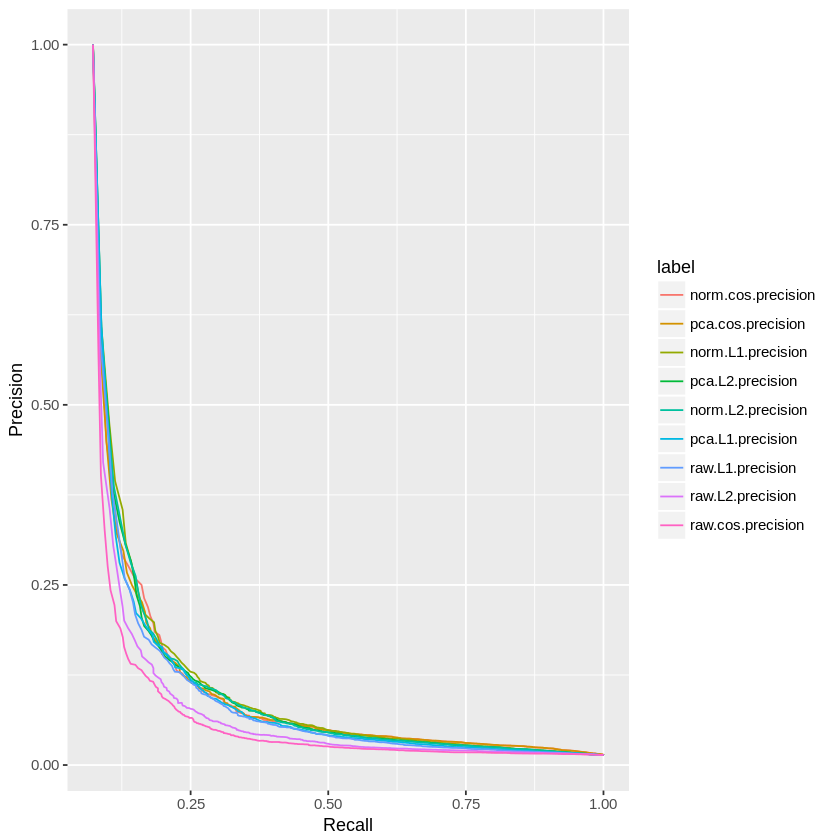

Warning message:
“Removed 8082 rows containing missing values (geom_path).”

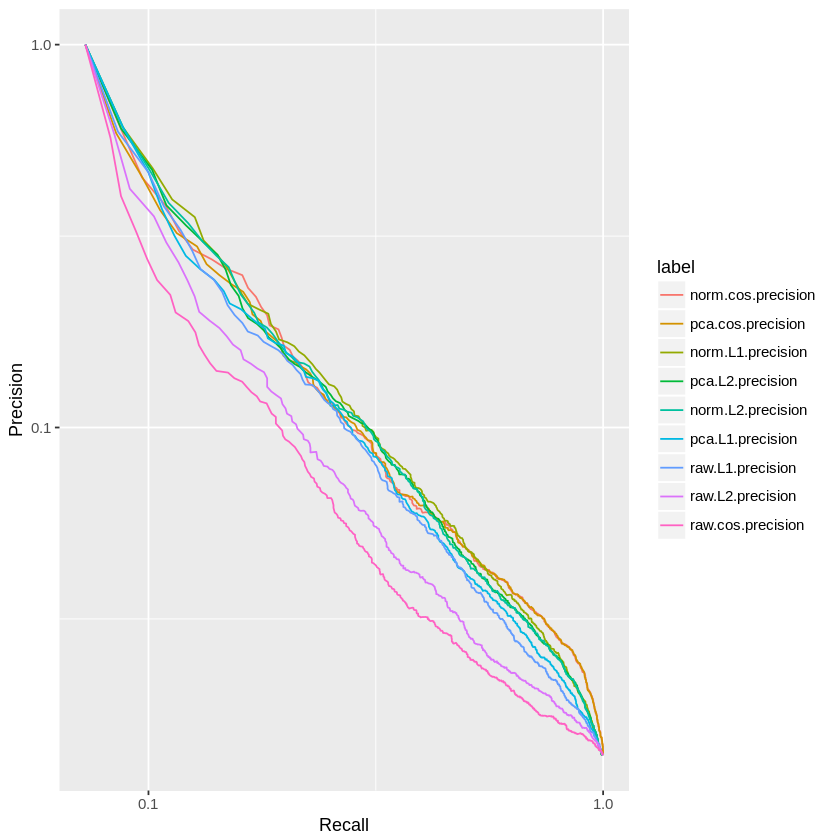

Warning message:
“Removed 8082 rows containing missing values (geom_path).”

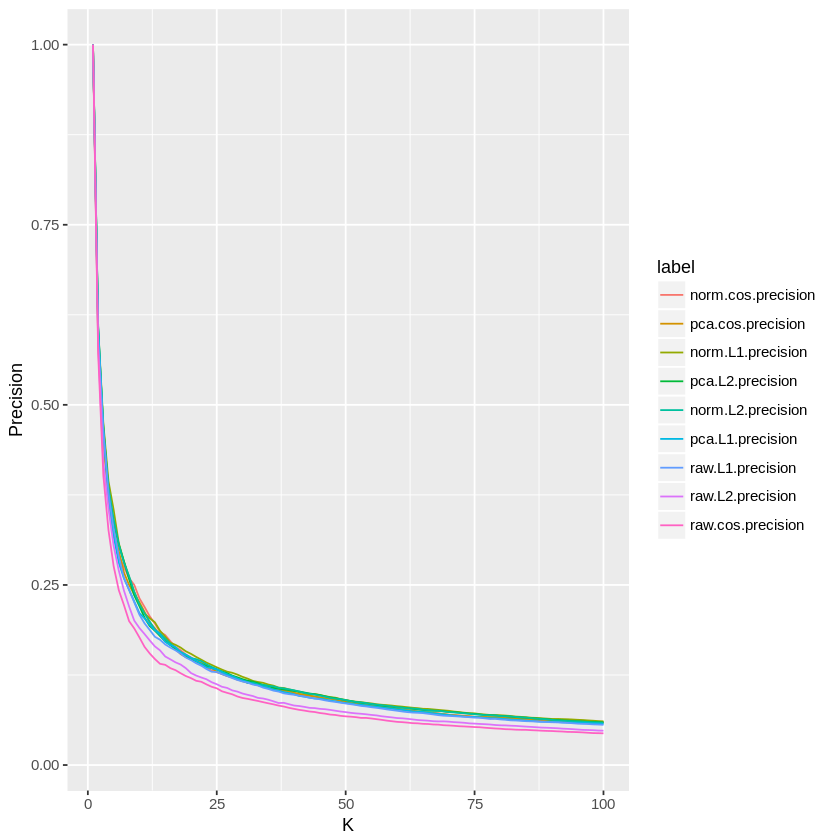

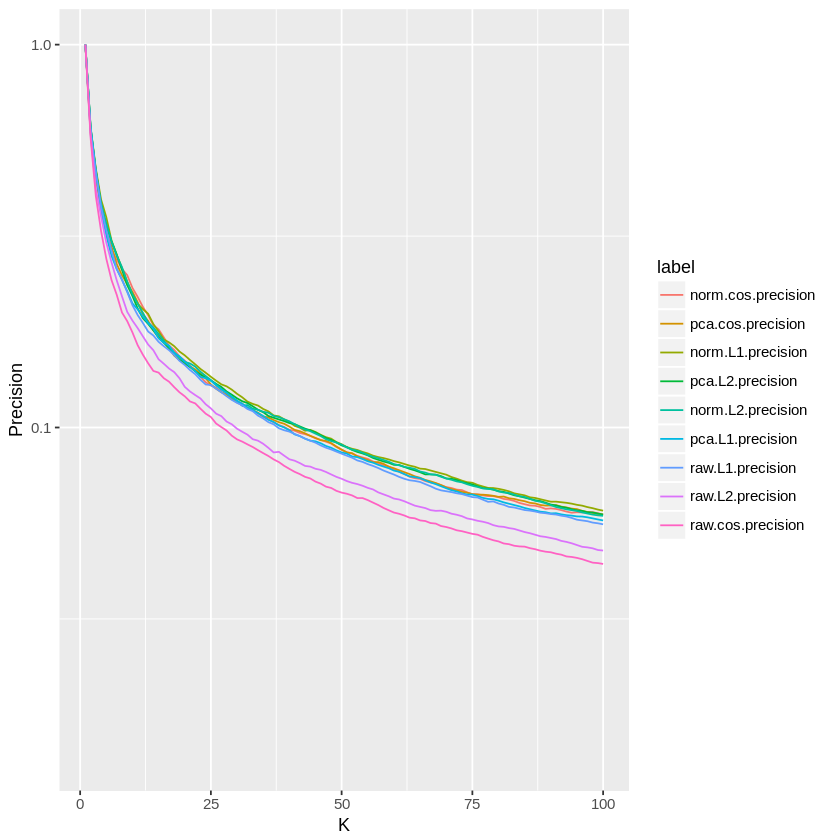

In [233]:
#TODO: Pick one
plot.evaluate.multi(df.evaluation[c(1, 6:length(df.evaluation))])
plot.evaluate.multi(df.evaluation[c(1, 6:length(df.evaluation))], x.log = T, y.log = T)
plot.evaluate.multi(df.evaluation[c(1, 6:length(df.evaluation))], k.as.x = T)
plot.evaluate.multi(df.evaluation[c(1, 6:length(df.evaluation))], k.as.x = T, y.log = T)